# Image Segmentation Task 3

In [1]:
!pip install positional_encodings;
!pip install cityscapesscripts;

     |████████████████████████████████| 472 kB 12.1 MB/s eta 0:00:01
     |████████████████████████████████| 45 kB 2.7 MB/s  eta 0:00:01
     |████████████████████████████████| 2.2 MB 16.7 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 4.2 MB/s  eta 0:00:01


### Imports

In [1]:
import os
import copy
import math
import random
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from os.path import join as pjoin

from torch.utils.data import DataLoader
from datasets.cityscapes import cityscapesDataset
from datasets.pascalvoc import pascalVOCDataset

### Setup

In [2]:
# reproducibility setups
torch.manual_seed(253452757)
random.seed(253452757)
np.random.seed(253452757)

In [3]:
local_path = "./Cityscapes"
os.environ["CUDA_VISIBLE_DEVICES"]="2" 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Hyperparameters

In [4]:
bs = 5
epochs = 15
learning_rate = 0.0002

### Dataset and Dataloader

In [5]:
training_data = cityscapesDataset(local_path, split="train")
training_data_raw = cityscapesDataset(local_path, split="train", is_transform=False)
validation_data = cityscapesDataset(local_path, split="val")
test_data = cityscapesDataset(local_path, split="test")

Annotations files processed
Annotations files processed
Annotations files processed
Annotations files processed


In [6]:
dataset_sizes = {
    'train': len(training_data),
    'val': len(validation_data),
    'test': len(test_data),
    'total': len(training_data) + len(validation_data) + len(test_data)
}

dataset_sizes

{'train': 2975, 'val': 500, 'test': 1525, 'total': 5000}

In [7]:
dataloaders = {
    'train': DataLoader(training_data, batch_size=bs, shuffle=True),
    'val': DataLoader(validation_data, batch_size=bs, shuffle=True),
    'test': DataLoader(test_data, batch_size=bs, shuffle=True),
}

In [8]:
img, lbl = training_data[0]

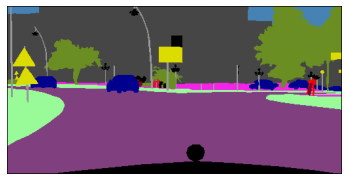

In [9]:
training_data.decode_segmap(lbl.numpy(), plot=True)

### Model setup

In [10]:
import importlib
import networks.r2unet_hanet 
import networks.hanet
importlib.reload(networks.hanet)
importlib.reload(networks.r2unet_hanet)

<module 'networks.r2unet_hanet' from '/project/simple-imageseg/networks/r2unet_hanet.py'>

In [ ]:
loss_f = nn.CrossEntropyLoss(ignore_index = 255)

#### R2UNet64 + 1 HANet layer

In [ ]:
model1 = networks.r2unet_hanet.R2Unet64HANet(hanet_layers=1).to(device)

In [ ]:
optimizer1 = torch.optim.Adam(model1.parameters(), lr = learning_rate)

#### R2UNet64 + 2 HANet layers

In [ ]:
model2 = networks.r2unet_hanet.R2Unet64HANet(hanet_layers=2).to(device)

In [ ]:
optimizer2 = torch.optim.Adam(model2.parameters(), lr = learning_rate)

#### R2UNet64 + 3 HANet layers

In [11]:
model3 = networks.r2unet_hanet.R2Unet64HANet(hanet_layers=3).to(device)

In [31]:
optimizer3 = torch.optim.Adam(model3.parameters(), lr = learning_rate)

### Training

In [13]:
import training
importlib.reload(training)

<module 'training' from '/project/simple-imageseg/training.py'>

#### R2UNet64 + 1 HANet layer

In [ ]:
model_path1 = 'models/r2unet_hanet64/1'
if not os.path.isdir(model_path1):
    os.makedirs(model_path1)

In [ ]:
model = training.train(model1, dataloaders, dataset_sizes, 
                       model_path1, loss_f, optimizer1, epochs)

#### R2UNet64 + 2 HANet layers

In [ ]:
model_path2 = 'models/r2unet_hanet64/2'
if not os.path.isdir(model_path2):
    os.makedirs(model_path2)

In [ ]:
model2 = training.train(model2, dataloaders, dataset_sizes, 
                       model_path2, loss_f, optimizer2, epochs)

#### R2UNet64 + 3 HANet layers

In [12]:
model_path3 = 'models/r2unet_hanet64/3'
if not os.path.isdir(model_path3):
    os.makedirs(model_path3)

In [ ]:
model3 = training.train(model3, dataloaders, dataset_sizes, 
                       model_path3, loss_f, optimizer3, epochs)

### Evaluate the results

In [19]:
import evaluation
importlib.reload(evaluation)

<module 'evaluation' from '/project/simple-imageseg/evaluation.py'>

#### R2UNet64 + 1 HANet layer

In [ ]:
checkpoint1 = torch.load(pjoin(model_path1, "epoch-{}.pt".format(epochs-1)))

In [ ]:
model1.load_state_dict(checkpoint1['model_state_dict'])

In [ ]:
val_report1 = evaluation.EvaluationReport.from_model(dataloaders['val'], model1, labels=list(range(19)))

In [ ]:
val_report1.get_metrics(average="macro")

In [ ]:
val_report1.get_metrics(average="weighted")

#### R2UNet64 + 2 HANet layers

In [ ]:
checkpoint2 = torch.load(pjoin(model_path2, "epoch-{}.pt".format(epochs-1)))

In [ ]:
model2.load_state_dict(checkpoint2['model_state_dict'])

In [ ]:
val_report2 = evaluation.EvaluationReport.from_model(dataloaders['val'], model2, labels=list(range(19)))

In [ ]:
val_report2.get_metrics(average="weighted")

#### R2UNet64 + 3 HANet layers

In [13]:
checkpoint3 = torch.load(pjoin(model_path3, "epoch-{}.pt".format(epochs-1)))

In [14]:
model3.load_state_dict(checkpoint3['model_state_dict'])

<All keys matched successfully>

In [22]:
val_report3 = evaluation.EvaluationReport.from_model(dataloaders['val'], model3, labels=list(range(19)))

In [23]:
val_report3.get_metrics(average="macro")

{'accuracy': 0.9225,
 'sensitivity': 0.1397,
 'specificity': 0.9592,
 'dice_coeff': 0.128,
 'jaccard_sim': 0.0823,
 'precision': 0.303,
 'recall': 0.1397,
 'f1_score': 0.128}

In [24]:
val_report3.get_metrics(average="weighted")

{'accuracy': 0.7868,
 'sensitivity': 0.2633,
 'specificity': 0.9609,
 'dice_coeff': 0.3174,
 'jaccard_sim': 0.2009,
 'precision': 0.7788,
 'recall': 0.2633,
 'f1_score': 0.3174}

### Visualize the results

In [15]:
from utils import plot_seg_results

Select 5 images and predict their segmentation mask using the best weights:

In [16]:
img_size = (512,256)
init_pic = 123
n_pics = 5

In [17]:
inputs = torch.stack([training_data[i][0] for i in range(init_pic, init_pic + n_pics)])
images = [training_data_raw[i][0].resize(img_size) for i in range(init_pic, init_pic + n_pics)]
ground_truths = torch.stack([training_data[i][1] for i in range(init_pic, init_pic + n_pics)])
ground_truths = [training_data.decode_segmap(gt.numpy()) for gt in ground_truths]

#### R2Unet64 + 1 HANet layers

In [ ]:
outputs = model1(inputs.to(device))
predictions = torch.argmax(outputs.squeeze().cpu(), dim = 1)
predictions = [training_data.decode_segmap(pred.numpy()) for pred in predictions]

In [ ]:
plot_seg_results(images, ground_truths, predictions)

#### R2Unet64 + 2 HANet layers

In [ ]:
outputs = model2(inputs.to(device))
predictions = torch.argmax(outputs.squeeze().cpu(), dim = 1)
predictions = [training_data.decode_segmap(pred.numpy()) for pred in predictions]

In [ ]:
plot_seg_results(images, ground_truths, predictions)

#### R2Unet64 + 3 HANet layers

In [19]:
outputs = model3(inputs.to(device))
predictions = torch.argmax(outputs.squeeze().cpu(), dim = 1)
predictions = [training_data.decode_segmap(pred.numpy()) for pred in predictions]

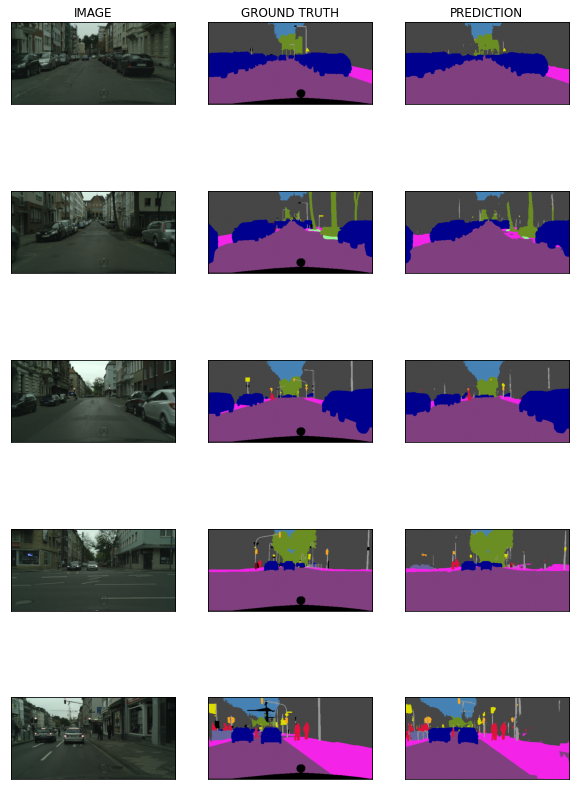

In [22]:
plot_seg_results(images, ground_truths, predictions)